# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [220]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning to Detect Bedroom Occupancy
As a side analysis, this notebook explores how we can use machine learning alongside IAQ measurements from the Beacon to determine when participants are occupying their bedrooms. 

---

<a id="toc"></a>

# Table of Contents
1. Package Import
2. Notes on Anlysis
3. Notes on Data Used
4. Pre-Processing
5. [Inspection](#inspection)

## Package Import

In [221]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import occupancy_detection

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

---

# Notes on Analysis

In [222]:
occ_det = occupancy_detection.Classify(data_dir="../data")

---

# Notes on Data Used
The necesary data are imported when insantiating a `calculate` object. 

## Beacon Data
We use two, previously-created beacon datasets:

1. **All**: All the IAQ measurements made by the beacons indexed by the timestamp.
2. **Nightly Measurements**: IAQ Measurements made by the beacons during Fitbit identified sleep events which have also been cross-referenced with GPS data to confirm participants are in the same location as the beacon during sleep events.

From these datasets, we are primarly concerned with the CO$_2$ data since increasing concentrations should be a direct result of the space being occupied. However, there are other IAQ parameters like TVOCs that we might also be able to use as input features to help improve the accuracy of the model.

We leverage IAQ data that we have already identified come from periods when participants are home and asleep -- Nightly Measurements. These data are _likely_ from periods when participants are in their bedrooms (although they could have fallen asleep on the couch, for example). Therefore, we can use these periods to label the IAQ measurements as "occupied" times. 

## Beiwe GPS Data
We also need to label IAQ data from periods when bedrooms are "unoccupied". Since the Nightly Measurements are only from Fitbit-detected sleep episodes, there are likely short periods prior to and after the episodes where the participant is occupying their bedroom. Therefore we cannot simply label all other times outside the Nightly Measurements as unoccupied. To give certainty to unoccupied periods, we should use the GPS data and label all beacon timestamps as unoccupied periods when GPS traces confirm that participants are not at home. 

## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information. This dataset contains other information including the sex of the individual and the estimated volume of their bedrooms (depends on the dwelling type). 

## Fitbit Data
We don't really _need_ Fitbit data for this analysis, but we did technically use it to develop the Nightly Measurements for the Beacon so I will include this note.

---

# Pre-Processing
We need to pre-process the data in the following ways:

1. **Labeling**: We will have to label periods of IAQ measurements when the bedroom is occupied and unoccupied. The idea is simple enough -- use Nightly Measurements for occupied, and times when GPS data have the participant elsewhere for unoccupied -- but, in practice, it might be challenging. 
2. **Downsample**: I don't think a resolution of 2 minutes is necessary for this kind of analysis, but I also don't want to lose out on any important information by downsampling to too small of a resolution. I think something in the neighborhood of 15 to 30 minutes is appropriate and probably more realistic. 


## Adding Labels

### `occupied` Labels
We can include `occupied` labels by looking at the nightly beacon data. The `home` column includes a flag that denotes if GPS data confirm participants are home (1), not home (0), or weren't confirmed home by gps (-1). We want to ensure that nights are labeled when we are _certain_ participants are home so we only consider IAQ measurements when `home == 1`.

#### Checking the number of available home sleep periods for each participant

In [223]:
for pt in occ_det.beacon_nightly["beiwe"].unique():
    data_pt = occ_det.beacon_nightly[occ_det.beacon_nightly["beiwe"] == pt]
    print(f"{pt}: {len(data_pt.groupby('start_time').count())}")

nvtfpaor: 7
lkkjddam: 84
itmylz3g: 29
zdpffrox: 28
qh34m4r9: 48
tmexej5v: 51
xlw5ntd5: 13
idbkjh8u: 14
kyj367pi: 29
e73a1pd5: 3
745vq78e: 27
awa8uces: 27
vr9j5rry: 40
olaxadz5: 25
rnse61g4: 5
4i7679py: 9
9jtzsuu8: 33
xdbdrk6e: 18
i31pt4b4: 26
tlmlq19s: 81
9xmhtq74: 19
i4w8dx6l: 16


<div class="alert-block alert alert-warning">
    
Using just `home == 1` might give us too few occupied labels for certain participants so we might consider using 0 and 1 to have more nights.
<div>

### `unoccupied` Labels
The `unoccupied` label is determined by looking at the overlap of the available GPS data from periods outside of the Nightly Measurements and the remaining of the Beacon IAQ measurements. 

### Label Distribution
Checking on the labels.

In [226]:
occ_det.add_label()

In [227]:
for label in occ_det.data["label"].unique():
    print(f"{label}:\t{len(occ_det.data[occ_det.data['label'] == label])}")

unoccupied:	86028
occupied:	82407


<div class="alert-block alert alert-warning">
    
We actually have only a few thousand more unoccupied data points which is most likely attributed to the fact that we get to add all data points from the sleep epsidoe once we confirm the participant is home compared to only being able to label occupied data points when the GPS coordinates overlap. 
    
There are probably more novel ways to get unoccupied data points, but for right now, we will simply opt for this simplified approach.
<div>

## Resampling
Now we will downsample the data to periods of 15 minutes to make the training/testing faster although we could neglect this step and simply use all available data. 

In [228]:
#occ_det.resample_data()

<div class="alert-block alert alert-danger">
    
Issues with resampling because of irregular time steps between measurments means that we should jsut keep the data. More data never hurt anyone, right?
<div>

---

<a id="inspection"></a>

[Back to ToC](#toc)
# Inspection
We want to take a quick look at the data to make sure that we are able to predict occupancy.

## CO$_2$ Distributions for Occupied vs Unoccupied Periods
The easiest comparison is to look at CO$_2$ concentrations to see if there is a noticeable difference in the distribution of measurements. However, the background concentrations could vary by participant so we need to look on a participant level.

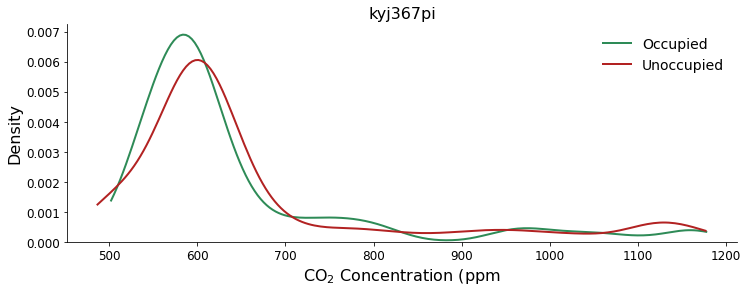

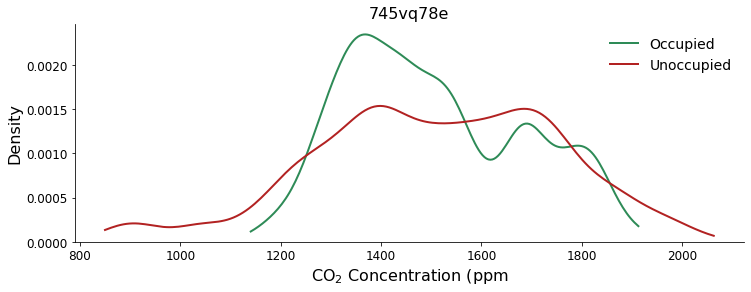

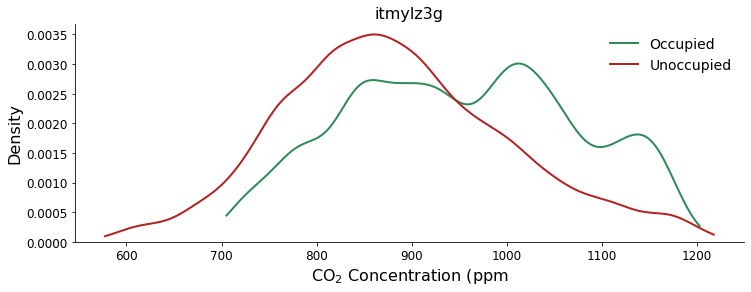

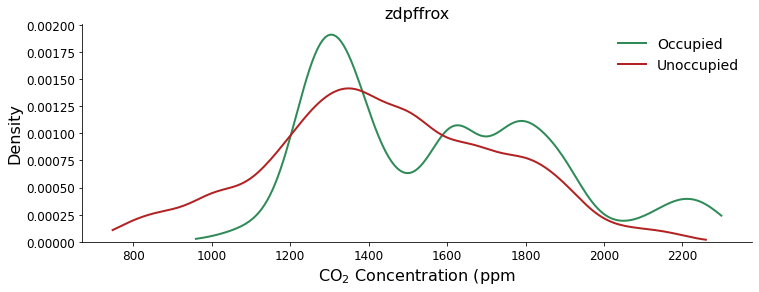

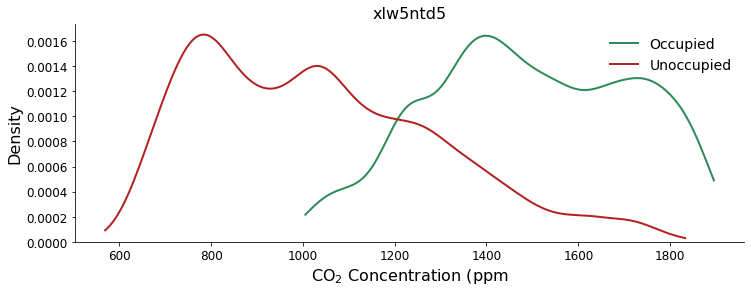

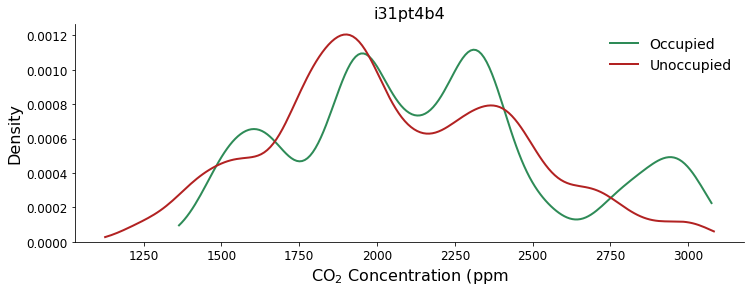

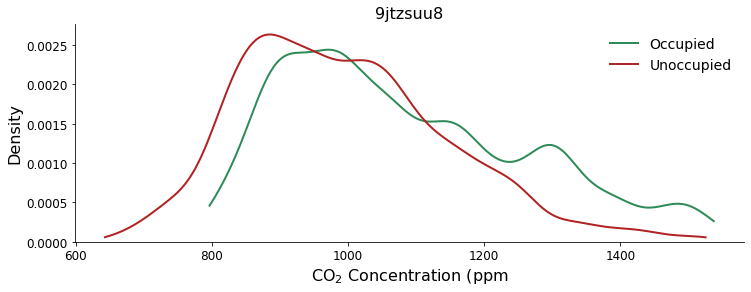

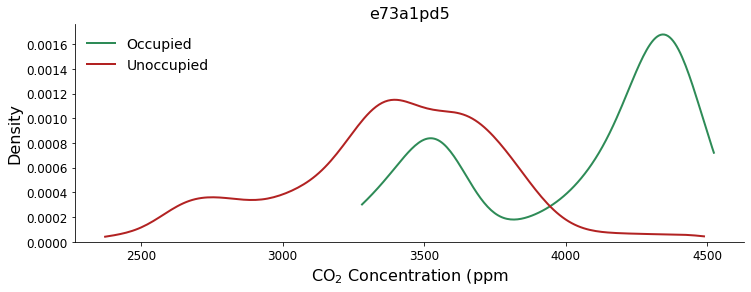

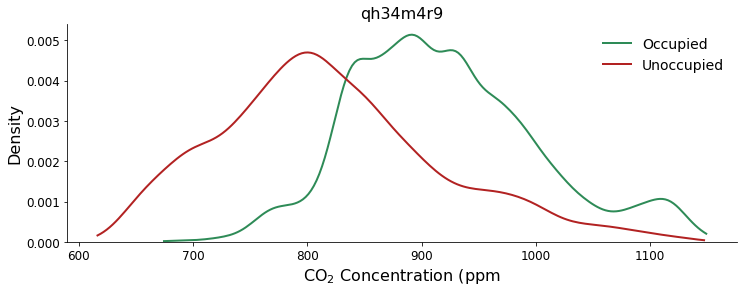

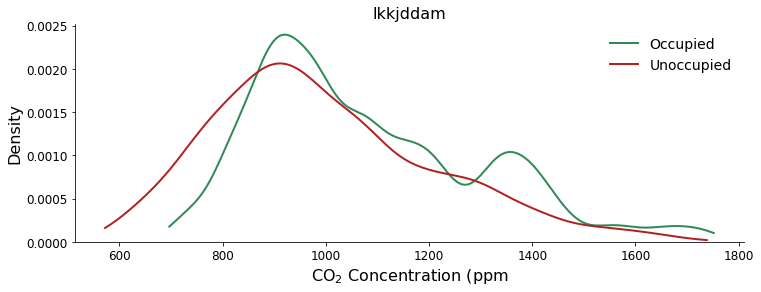

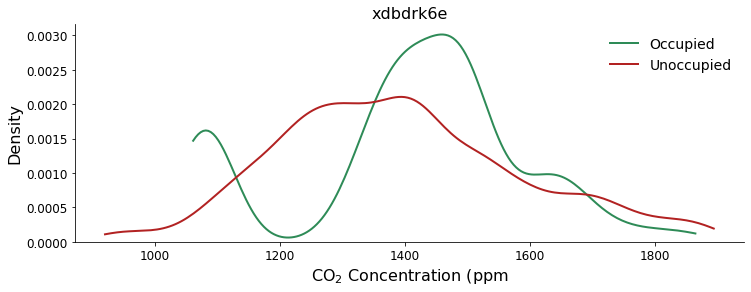

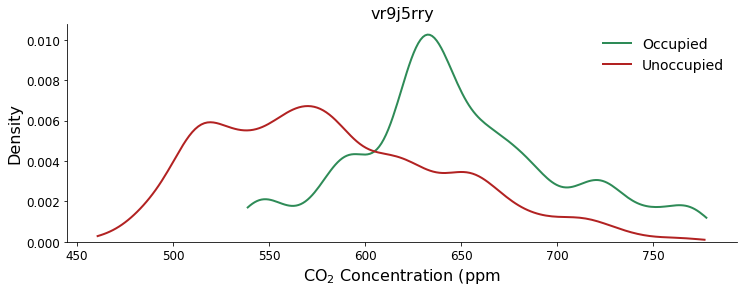

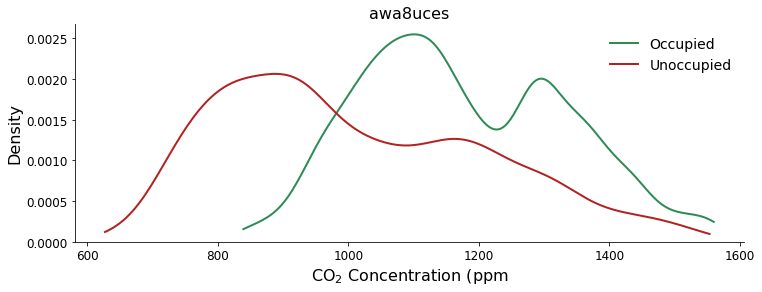

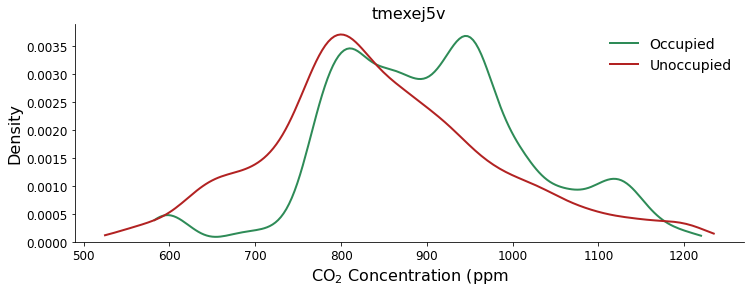

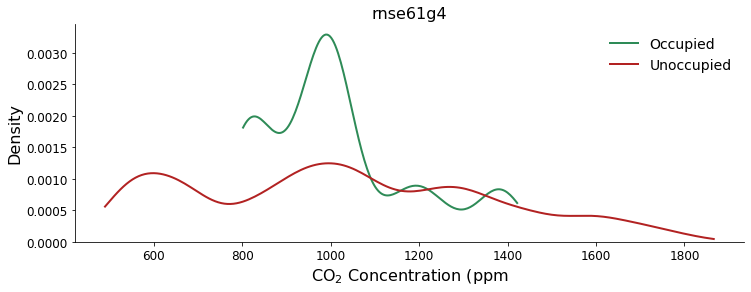

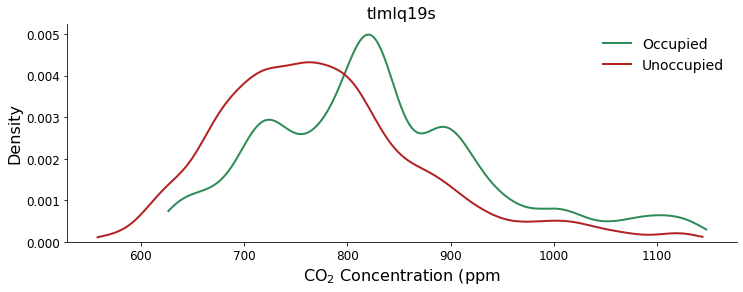

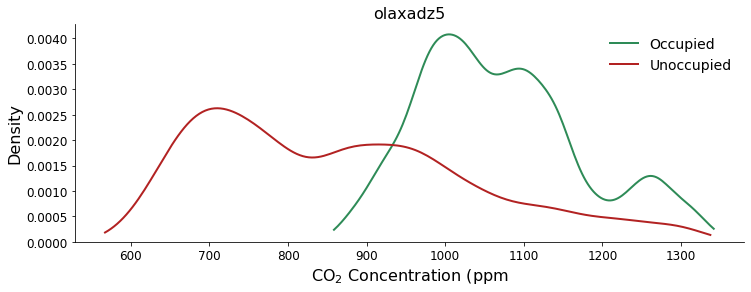

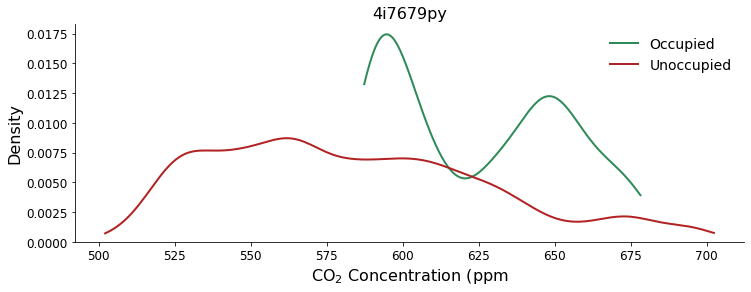

In [229]:
occ_det.co2_comparison()

<div class="alert-block alert alert-warning">
    
The differences in `co2` distributions are not as stark as I would have hoped and for some participants, the differences are _opposite_ what I would have expected (lower concentrations during occupied periods). 
<div>

---